## Learn ipums CPDs and structure

In [ ]:
import pandas as pd

ipums = pd.read_csv('data/household/ipums.csv')

columns_to_keep_ind = ['SEX', 'AGE', 'NATION',
                   'NCHILD', 'PERSONS', 'EMARST',
                   'EEMPSTAT', 'EDUCES']

ipums = ipums.loc[:, columns_to_keep_ind]

# rename columns
new_column_names = {'SEX': 'G', 'AGE': 'DA', 'NATION': 'N',
                    'NCHILD': 'Ch', 'EMARST': 'S',
                    'EEMPSTAT': 'U', 'EDUCES': 'E', 'PERSONS': 'HR'}
ipums.rename(columns=new_column_names, inplace=True)

ipums.dropna(inplace=True)

# drop rows with with age out of the range of the study
indexAge = ipums[(ipums['DA'] < 15) | (ipums['DA'] > 74)].index
ipums.drop(indexAge , inplace=True)

print(ipums.shape)

(89795, 8)


In [77]:
#############
# HARMONITZAR LES DADES
#############
G_map = {1: 1, 2: 0} # 1: Male, 2: Female
ipums['G'] = ipums['G'].map(lambda x: G_map.get(x))

def discretize_age(x):
    # age already satisfies 15>=x<=74
    if x < 25:
        return 1
    elif x < 35:
        return 2
    elif x < 45:
        return 3
    elif x < 55:
        return 4
    elif x < 65:
        return 5
    else:
        return 6

ipums['DA'] = ipums['DA'].apply(discretize_age)

ipums['N'] = ipums['N'].map(lambda x: 0 if x==43120 else 1)

ipums['Ch'] = ipums['Ch'].map(lambda x: 0 if x==0 else 1)

S_map = {1: 2, 2: 0, 3: 1, 4: 1, 5: 1}
ipums['S'] = ipums['S'].map(lambda x: S_map.get(x))

ipums['U'] = ipums['U'].map(lambda x: 0 if (x==120 or x==121) else 1)

def discretize_edu(x):
    # age already satisfies 15>=x<=74
    if x < 300:
        return 1
    elif x < 320:
        return 2
    elif x < 410:
        return 3
    elif x < 431:
        return 4
    else:
        return 5

ipums['E'] = ipums['E'].apply(discretize_edu)

ipums['HR'] = ipums['HR'].map(lambda x: 4 if x>4 else x)

In [78]:
from pgmpy.estimators import BicScore, MmhcEstimator

est = MmhcEstimator(ipums)
# Estimate the structure
ipums_best_structure_model = est.estimate(scoring_method=BicScore(ipums))

##################

print(ipums_best_structure_model.edges()) # (A,B) means an edge A->B

# create a dict to visualize the dependendies
depend_dict = {}
for connection in ipums_best_structure_model.edges():
    
    if not connection[0] in depend_dict.keys():
        depend_dict[connection[0]] = [connection[1]]
    else:
        depend_dict[connection[0]].append(connection[1])

  0%|          | 19/1000000 [00:01<19:20:26, 14.36it/s]

[('G', 'Ch'), ('DA', 'S'), ('DA', 'E'), ('DA', 'HR'), ('DA', 'Ch'), ('DA', 'U'), ('N', 'DA'), ('N', 'S'), ('N', 'E'), ('HR', 'Ch'), ('HR', 'S'), ('S', 'Ch'), ('S', 'G'), ('U', 'G'), ('E', 'G'), ('E', 'HR'), ('E', 'U')]


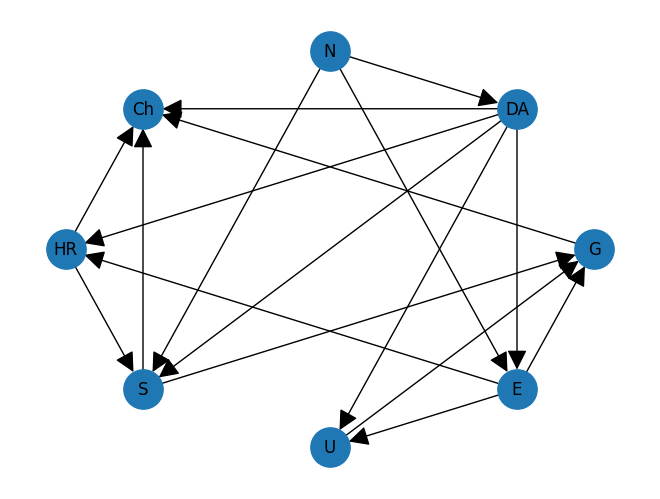

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.circular_layout(ipums_best_structure_model) # Create a layout for nodes
nx.draw(ipums_best_structure_model, pos, with_labels=True, arrowsize=30, node_size=800)
plt.show()

nodes_in_DAG = set()
for edge in ipums_best_structure_model.edges():
    nodes_in_DAG.add(edge[0])
    nodes_in_DAG.add(edge[1])

In [80]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization

ipums_model = BayesianNetwork(ipums_best_structure_model.edges())

# We need to manually add independent variables, as they do no appear in the DAG
indep_variables = [variables for variables in ipums.columns if variables not in nodes_in_DAG]
for node in indep_variables:
    ipums_model.add_node(node)

ipums_model.fit(ipums, estimator=ExpectationMaximization)

for cpd in ipums_model.get_cpds():
    print(cpd)

  0%|          | 0/100 [00:05<?, ?it/s]

+------+--------------------+-----+---------------------+
| E    | E(1)               | ... | E(5)                |
+------+--------------------+-----+---------------------+
| S    | S(0)               | ... | S(2)                |
+------+--------------------+-----+---------------------+
| U    | U(0)               | ... | U(1)                |
+------+--------------------+-----+---------------------+
| G(0) | 0.6565612819402339 | ... | 0.5649317837291561  |
+------+--------------------+-----+---------------------+
| G(1) | 0.3434387180597661 | ... | 0.43506821627084385 |
+------+--------------------+-----+---------------------+
+-------+-------+-------+-------+-----+--------------------+
| DA    | DA(1) | DA(1) | DA(1) | ... | DA(6)              |
+-------+-------+-------+-------+-----+--------------------+
| G     | G(0)  | G(0)  | G(0)  | ... | G(1)               |
+-------+-------+-------+-------+-----+--------------------+
| HR    | HR(1) | HR(1) | HR(1) | ... | HR(4)            

## Learn valors_socials CPDs and structure, but fixing ipums structure

In [81]:
import pandas as pd

valors_socials = pd.read_csv('data/r21046_Valors_Socials_BD_CSVcodi_v1_0.csv')

# variables socio-demogràfiques i laborals
columns_to_keep_ind = ['DISTRICTE', 'SEXE', 'EDAT1574_1A6', 'NACIO_ACT_UE',
                   'HAB_RES_1A4', 'TE_FILLS_1A2', 'SITPERSONAL_1A4', 'CLASSESOC_ENT_1A5',
                   'SITLABORAL_1A9', 'ESTUDIS_1A6']

# Esborrant 'PROF_ACT_B' tenc totes les columnes!

# nivells d'importància
columns_to_keep_ind.extend(['IMP_PERS_FAM_1A4', 'IMP_PERS_AMIC_1A4','IMP_PERS_TEMPS_1A4',
                        'IMP_PERS_POLITICA_1A4', 'IMP_PERS_FEINA_1A4', 'IMP_PERS_RELIGIO_1A4', 'IMP_PERS_ECON_1A4',
                        'IMP_PERS_ESTUDIAR_1A4', 'IMP_PERS_DESENV_1A4'])

# nivells de satisfacció
columns_to_keep_ind.extend(['SATISF_PERS_1A10', 'SATISF_PERS_FAM_1A10','SATISF_PERS_AMIC_1A10',
                        'SATISF_PERS_TEMPS_1A10', 'SATISF_PERS_FEINA_1A10', 'SATISF_PERS_ECON_1A10',
                        'SATISF_PERS_ESTUDIAR_1A10', 'SATISF_PERS_DESENV_1A10'])

# ideologia
columns_to_keep_ind.extend(['IDEO_1A8', 'IDEO_PARE_1A8', 'IDEO_MARE_1A8', 'IDEO_PARTIT', 'INTERES_POLITICA_1A4',
                        'ACORD_SOCIETAT_CONCEPT_Q01_1A3', 'ACORD_SOCIETAT_CONCEPT_Q02_1A3', 'ACORD_SOCIETAT_CONCEPT_Q03_1A3',
                        'SENTPERTI_1A5', 'RELIGIO','ACORD_SOCIETAT_CONCEPT_Q05_1A3', 'ACORD_SOCIETAT_CONCEPT_Q06_1A3', 'ACORD_SOCIETAT_CONCEPT_Q09_1A3',
                        'ACORD_SOCIETAT_JUSTIFICAR_Q04_1A3', 'PRIO_ESTAT_POLITICA_MEDIAMB_1A2',
                        'IMPACTE_IMMIG_PAIS_1A10', 'CONFIA_INSTITUCIO_Q01_1A4',
                        'CONFIA_INSTITUCIO_Q11_1A4', 'CONFIA_INSTITUCIO_Q12_1A4'])

valors_socials = valors_socials.loc[:, columns_to_keep_ind]

# rename columns
new_column_names = {'DISTRICTE': 'D', 'SEXE': 'G', 'EDAT1574_1A6': 'DA', 'NACIO_ACT_UE': 'N',
                    'TE_FILLS_1A2': 'Ch', 'SITPERSONAL_1A4': 'S', 'CLASSESOC_ENT_1A5': 'C',
                    'SITLABORAL_1A9': 'U', 'ESTUDIS_1A6': 'E', 'HAB_RES_1A4': 'HR',
                    'IMP_PERS_FAM_1A4': 'IF', 'IMP_PERS_AMIC_1A4': 'IA', 'IMP_PERS_TEMPS_1A4': 'IT',
                    'SATISF_PERS_1A10': 'Sat', 'SATISF_PERS_FAM_1A10': 'SF', 'SATISF_PERS_AMIC_1A10': 'SA',
                    'SATISF_PERS_TEMPS_1A10': 'ST', 'IDEO_1A8': 'Ideo', 'IDEO_PARTIT': 'IP',
                    'ACORD_SOCIETAT_CONCEPT_Q01_1A3': 'Cap', 'ACORD_SOCIETAT_CONCEPT_Q02_1A3': 'Soc', 'ACORD_SOCIETAT_CONCEPT_Q03_1A3': 'Com',
                    'SENTPERTI_1A5': 'Indep', 'RELIGIO': 'R',

                    'IMP_PERS_POLITICA_1A4': 'Ipol', 'IMP_PERS_FEINA_1A4': 'Iemp', 'IMP_PERS_RELIGIO_1A4': 'Irel', 'IMP_PERS_ECON_1A4': 'Iecon',
                    'IMP_PERS_ESTUDIAR_1A4': 'IE', 'IMP_PERS_DESENV_1A4': 'Ides',
                    'SATISF_PERS_FEINA_1A10': 'Semp', 'SATISF_PERS_ECON_1A10': 'Secon', 'SATISF_PERS_ESTUDIAR_1A10': 'SE', 'SATISF_PERS_DESENV_1A10': 'Sdes',
                    'IDEO_PARE_1A8': 'Ipare', 'IDEO_MARE_1A8': 'Imare', 'INTERES_POLITICA_1A4': 'InterPolitica',
                    'ACORD_SOCIETAT_CONCEPT_Q05_1A3': 'Femin', 'ACORD_SOCIETAT_CONCEPT_Q06_1A3': 'Ecolog', 'ACORD_SOCIETAT_CONCEPT_Q09_1A3': 'Multiculturalism',
                    'ACORD_SOCIETAT_JUSTIFICAR_Q04_1A3': 'JustOkupa', 'PRIO_ESTAT_POLITICA_MEDIAMB_1A2': 'EconVsMedi',
                    'IMPACTE_IMMIG_PAIS_1A10': 'Immig', 'CONFIA_INSTITUCIO_Q01_1A4': 'ConfMon',
                    'CONFIA_INSTITUCIO_Q11_1A4': 'ConfPol', 'CONFIA_INSTITUCIO_Q12_1A4': 'ConfGov'
                    }
valors_socials.rename(columns=new_column_names, inplace=True)

valors_socials.dropna(inplace=True)

# delete rows with 'no answer' (99)
valors_socials = valors_socials[valors_socials < 99].dropna()

print(valors_socials.shape)
valors_socials.columns

(1350, 46)


Index(['D', 'G', 'DA', 'N', 'HR', 'Ch', 'S', 'C', 'U', 'E', 'IF', 'IA', 'IT',
       'Ipol', 'Iemp', 'Irel', 'Iecon', 'IE', 'Ides', 'Sat', 'SF', 'SA', 'ST',
       'Semp', 'Secon', 'SE', 'Sdes', 'Ideo', 'Ipare', 'Imare', 'IP',
       'InterPolitica', 'Cap', 'Soc', 'Com', 'Indep', 'R', 'Femin', 'Ecolog',
       'Multiculturalism', 'JustOkupa', 'EconVsMedi', 'Immig', 'ConfMon',
       'ConfPol', 'ConfGov'],
      dtype='object')

In [82]:
# HARMONITZAR LES DADES

G_map = {1: 0, 2: 1} # 1: Dona, 2: Home
valors_socials['G'] = valors_socials['G'].map(lambda x: G_map.get(x))

'''
Ciutat Vella: 1
Eixample: 2
Sants-Montjuïc: 3
Les Corts: 4
Sarrià-Sant Gervasi: 5 
Gràcia: 6
Horta-Guinardó: 7  
Nou Barris: 8 
Sant Andreu: 9 
Sant Martí: 10
'''
valors_socials['D'] = valors_socials['D'].map(lambda x: x-1)

'''
1. No ha acabat els estudis obligatoris
2. Obligatoris (primària, EGB, ESO)
3. Secundaris generals (batxillerat, PREU, BUP, COU)
4. Secundaris professionals (comerç, FP1, FP2, mòduls grau mitjà/superior)
5. Universitaris (graus, diplomatura, llicenciatura)
6. Post universitaris (màster, postgrau, doctorat que requereixin titulació universitària)
'''
valors_socials['E'] = valors_socials['E'].map(lambda x: 5 if x==6 else x)

''' 'DA' is ok
1. De 15 a 24 anys  
2. De 25 a 34 anys  
3. De 35 a 44 anys  
4. De 45 a 54 anys  
5. De 55 a 64 anys  
6. De 65 a 74 anys
'''

N_map = {1: 0, 2: 1, 3: 1}
''' Variable no es diu igual!
1. Espanyola
2. Resta
3. Resta
'''
valors_socials['N'] = valors_socials['N'].map(lambda x: N_map.get(x))

'''
1. Treballa per compte propi (com autònom/a o amb contractació de personal)
2. Treballa per compte propi, però actualment amb aturada d'activitat
3. Treballa per compte d'altri (com assalariat/ada) 
4. Treballa per compte d'altri actualment afectat/da per un ERO amb reducció o ERTO
5. Cobra jubilació, prejubilació o pensió o incapacitació laboral
6. Està a l'atur (inclou ERO total) / Busca feina
7. Tasques de la llar (no remunerades)
8. Estudia
9. Rendista
'''
valors_socials['U'] = valors_socials['U'].map(lambda x: 0 if x==6 else 1)

S_map = {1: 2, 2: 0, 3: 1, 4: 1}
'''
1. Solter/a
2. Casat/ada / amb parella (amb la que conviu)
3. Separat/ada / divorciat/ada
4. Vidu / vídua

ha de ser 0: married, 1: divorced/vidu, 2: single
'''
valors_socials['S'] = valors_socials['S'].map(lambda x: S_map.get(x))

''' 'HR' ESTÀ OK
1. Viu sol
2. Viu amb 1 persona
3. Viu amb 2 persones
4. Viu amb 3+ persones
'''

Ch_map = {2: 0, 1: 1} # 1: té fills, 2: no té fills
valors_socials['Ch'] = valors_socials['Ch'].map(lambda x: Ch_map.get(x))

In [83]:
from pgmpy.estimators import HillClimbSearch, BicScore

# fix ipums dependencies
fixed_dependencies = ipums_best_structure_model.edges()

est = HillClimbSearch(valors_socials) # Estimate the structure
VS_best_structure_model = est.estimate(scoring_method=BicScore(valors_socials),
                                    fixed_edges=fixed_dependencies)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 28/1000000 [00:09<90:45:07,  3.06it/s] 


In [84]:
# remove edges that are in conflict with ipums
ipums_list = list(ipums_best_structure_model.edges())
ipums_nodes = set(ipums.columns)
copy_best_structure_model = VS_best_structure_model.copy()

for edge in copy_best_structure_model.edges():
    if edge[0] in ipums_nodes and edge[1] in ipums_nodes and edge not in ipums_list:
            VS_best_structure_model.remove_edge(edge[0], edge[1])


##################

print(VS_best_structure_model.edges()) # (A,B) means an edge A->B

# create a dict to visualize the dependendies
depend_dict = {}
for connection in VS_best_structure_model.edges():
    
    if not connection[0] in depend_dict.keys():
        depend_dict[connection[0]] = [connection[1]]
    else:
        depend_dict[connection[0]].append(connection[1])

[('G', 'Ch'), ('DA', 'U'), ('DA', 'Ch'), ('DA', 'E'), ('DA', 'HR'), ('DA', 'S'), ('N', 'S'), ('N', 'E'), ('N', 'DA'), ('N', 'Indep'), ('N', 'R'), ('HR', 'S'), ('HR', 'Ch'), ('S', 'Ch'), ('S', 'G'), ('U', 'G'), ('U', 'Semp'), ('U', 'Secon'), ('E', 'HR'), ('E', 'G'), ('E', 'U'), ('IA', 'IT'), ('IA', 'IF'), ('Iemp', 'IE'), ('Irel', 'ConfMon'), ('IE', 'Ides'), ('SA', 'IA'), ('Sdes', 'Sat'), ('Ideo', 'IP'), ('Ideo', 'InterPolitica'), ('Ideo', 'Soc'), ('Imare', 'Ipare'), ('Imare', 'Ideo'), ('IP', 'N'), ('InterPolitica', 'Ipol'), ('Soc', 'Com'), ('Soc', 'Femin'), ('Com', 'Cap'), ('R', 'Irel'), ('Femin', 'Ecolog'), ('Femin', 'Multiculturalism'), ('Ecolog', 'EconVsMedi'), ('ConfMon', 'ConfPol'), ('ConfPol', 'ConfGov'), ('ConfPol', 'JustOkupa')]


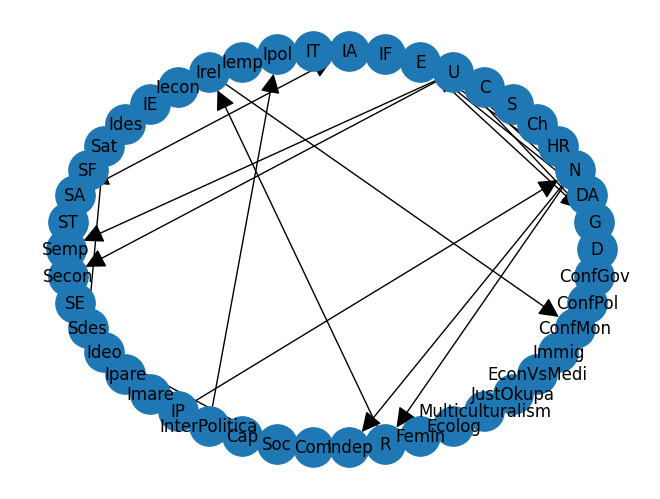

G -> ['Ch']
SA -> ['IA']
U -> ['G', 'Semp', 'Secon']
R -> ['Irel']
ConfPol -> ['ConfGov', 'JustOkupa']
InterPolitica -> ['Ipol']
DA -> ['U', 'Ch', 'E', 'HR', 'S']
Imare -> ['Ipare', 'Ideo']
E -> ['HR', 'G', 'U']
Ideo -> ['IP', 'InterPolitica', 'Soc']
IP -> ['N']
IA -> ['IT', 'IF']
HR -> ['S', 'Ch']
Soc -> ['Com', 'Femin']
N -> ['S', 'E', 'DA', 'Indep', 'R']
ConfMon -> ['ConfPol']
Com -> ['Cap']
IE -> ['Ides']
Ecolog -> ['EconVsMedi']
Irel -> ['ConfMon']
Femin -> ['Ecolog', 'Multiculturalism']
S -> ['Ch', 'G']
Sdes -> ['Sat']
Iemp -> ['IE']


In [85]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.circular_layout(VS_best_structure_model) # Create a layout for nodes
nx.draw(VS_best_structure_model, pos, with_labels=True, arrowsize=30, node_size=800)
plt.show()

nodes_in_DAG = set()
for edge in VS_best_structure_model.edges():
    nodes_in_DAG.add(edge[0])
    nodes_in_DAG.add(edge[1])

# nodes_in_DAG imposes an ordering of variables for the plot
for feature in nodes_in_DAG:
    for key in depend_dict.keys():
        if key == feature:
            print(str(key)+" -> "+str(depend_dict[key]))

In [86]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization

VS_model = BayesianNetwork(VS_best_structure_model.edges())

# We need to manually add independent variables, as they do no appear in the DAG
VS_indep_variables = [variables for variables in valors_socials.columns if variables not in nodes_in_DAG]
for node in VS_indep_variables:
    VS_model.add_node(node)

VS_model.fit(valors_socials, estimator=ExpectationMaximization)

  0%|          | 0/100 [00:02<?, ?it/s]


## Learn panel CPDs and structure, but fixing ipums structure

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

panelind = pd.read_csv('data/household/Matrius_K/K_INDI.csv',delimiter=';')
columns_to_keep_ind = ['KL012001EG2', 'L005001E', 'L007001E', 'KE001001EG3', 'KT002001EH1R3', 
                   'KL006001E', 'KF031001ER1', 'KR185001E', 'KR167001E', 'KR173001E', 'KR170001E','KR176001E', 'KR107001E',
                   'KR168001E', 'KR174001E', 'KR171001E', 'KR075001E', 'KR110001E',
                   'KR169001E', 'KR175001E', 'KR178001E', 'KR078001E', 'KR113001E',
                   'KP017001LG2']
panelind = panelind.loc[:, columns_to_keep_ind]
# rename columns
new_column_names = {'KL012001EG2': 'DA', 'L005001E': 'G', 'L007001E': 'N', 'KT002001EH1R3': 'U', 'KE001001EG3': 'E',
                    'KL006001E': 'S', 'KF031001ER1': 'Ch',
                    'KR185001E': 'Nam', 'KR167001E': 'Gam1', 'KR173001E': 'DAam1', 'KR170001E': 'Nam1', 'KR176001E': 'Uam1', 'KR107001E': 'Eam1',
                    'KR168001E': 'Gam2', 'KR174001E': 'DAam2', 'KR171001E': 'Nam2', 'KR075001E': 'Uam2', 'KR110001E': 'Eam2',
                    'KR169001E': 'Gam3', 'KR175001E': 'DAam3', 'KR178001E': 'Nam3', 'KR078001E': 'Uam3', 'KR113001E': 'Eam3',
                    'KP017001LG2': 'household_id'
                    }
panelind.rename(columns=new_column_names, inplace=True)

panelind = panelind[panelind['DA'] >= 15] # keep only people over 15
panelind = panelind.loc[(panelind >= 0).all(axis=1)] # negative values represent unanswered questions

panelllar = pd.read_csv('data/household/Matrius_K/K_LLAR.csv',delimiter=';') 
columns_to_keep_llar = ['P017001LG2', 'KL001001LR1', 'KL018001LR1']
panelllar = panelllar.loc[:, columns_to_keep_llar]
# rename columns
new_column_names = {'P017001LG2': 'household_id', 'KL001001LR1': 'HR', 'KL018001LR1': 'Tip'}
panelllar.rename(columns=new_column_names, inplace=True)

# merge them by household id, which is P017001L
merged_panel = pd.merge(panelind, panelllar, on='household_id', how='inner')

merged_panel.drop('household_id', axis=1, inplace=True) # once merged, we don't want household_id in the model
merged_panel.dropna(inplace=True)

print(merged_panel.shape)

(1481, 25)


C:\Users\mique\AppData\Local\Temp\ipykernel_20828\2966182871.py:4: DtypeWarning: Columns (37,38,41,45,48,59,61,101,102,115,127,140,185,243,245,249,288,290,306,307,497,500,528,534,539,541,542,546,549,550,562) have mixed types. Specify dtype option on import or set low_memory=False.
  panelind = pd.read_csv('data/household/Matrius_K/K_INDI.csv',delimiter=';')


In [97]:
# HARMONITZAR LES DADES

G_map = {1: 1, 2: 0}
merged_panel['G'] = merged_panel['G'].map(lambda x: G_map.get(x))

E_map = {1: 1, 2: 1, 3: 1, 4: 1,
         3: 2, 9: 2, 10: 2, 
         7: 3, 8: 3, 11: 3, 13: 3,
         5: 4, 6: 4, 8: 4, 9: 4,
         12: 5, 14: 5, 15: 5, 16: 5}
merged_panel['E'] = merged_panel['E'].map(lambda x: E_map.get(x))

def discretize_age(x):
    # age already satisfies 15>=x<=74
    if x < 25:
        return 1
    elif x < 35:
        return 2
    elif x < 45:
        return 3
    elif x < 55:
        return 4
    elif x < 65:
        return 5
    else:
        return 6

merged_panel['DA'] = merged_panel['DA'].apply(discretize_age)

N_map = {1: 0, 2: 0, 3: 1}
'''
ha de ser 0: Espanyola, 1: Resta
'''
merged_panel['N'] = merged_panel['N'].map(lambda x: N_map.get(x))

U_map = {1: 1, 2: 0, 3: 1}
'''
ha de ser 0: atur, 1: ocupat
'''
merged_panel['U'] = merged_panel['U'].map(lambda x: U_map.get(x))

S_map = {1: 0, 2: 2, 3: 1, 4: 1, 5: 1}
'''
ha de ser 0: married, 1: divorced/vidu, 2: single
'''
merged_panel['S'] = merged_panel['S'].map(lambda x: S_map.get(x))

merged_panel['Ch'] = merged_panel['Ch'].map(lambda x: 0 if x==0 else 1)

merged_panel['HR'] = merged_panel['HR'].map(lambda x: 4 if x>4 else x)

In [98]:
from pgmpy.estimators import HillClimbSearch, BicScore

# fix ipums dependencies
fixed_dependencies = ipums_best_structure_model.edges()

est = HillClimbSearch(merged_panel) # Estimate the structure
panels_best_structure_model = est.estimate(scoring_method=BicScore(merged_panel),
                                    fixed_edges=fixed_dependencies)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 16/1000000 [00:02<44:48:18,  6.20it/s]


In [99]:
# remove edges that are in conflict with ipums
ipums_list = list(ipums_best_structure_model.edges())
ipums_nodes = set(ipums.columns)
copy_best_structure_model = panels_best_structure_model.copy()

for edge in copy_best_structure_model.edges():
    if edge[0] in ipums_nodes and edge[1] in ipums_nodes and edge not in ipums_list:
            panels_best_structure_model.remove_edge(edge[0], edge[1])


##################

print(panels_best_structure_model.edges()) # (A,B) means an edge A->B

# create a dict to visualize the dependendies
depend_dict = {}
for connection in panels_best_structure_model.edges():
    
    if not connection[0] in depend_dict.keys():
        depend_dict[connection[0]] = [connection[1]]
    else:
        depend_dict[connection[0]].append(connection[1])

[('DA', 'U'), ('DA', 'Ch'), ('DA', 'E'), ('DA', 'HR'), ('DA', 'S'), ('DA', 'Uam2'), ('DA', 'Uam3'), ('DA', 'DAam1'), ('DA', 'DAam2'), ('G', 'Ch'), ('G', 'Gam1'), ('G', 'Gam2'), ('G', 'Gam3'), ('N', 'S'), ('N', 'E'), ('N', 'DA'), ('N', 'Uam1'), ('N', 'Nam3'), ('E', 'HR'), ('E', 'G'), ('E', 'U'), ('E', 'Eam1'), ('U', 'G'), ('S', 'Ch'), ('S', 'G'), ('Ch', 'DAam3'), ('Ch', 'Gam3'), ('Uam1', 'Nam3'), ('Eam1', 'Eam2'), ('Eam1', 'Eam3'), ('HR', 'S'), ('HR', 'Ch'), ('HR', 'Tip')]


In [100]:
print(copy_best_structure_model.edges())

[('DA', 'U'), ('DA', 'Ch'), ('DA', 'E'), ('DA', 'HR'), ('DA', 'S'), ('DA', 'Uam2'), ('DA', 'Uam3'), ('DA', 'DAam1'), ('DA', 'DAam2'), ('G', 'Ch'), ('G', 'Gam1'), ('G', 'Gam2'), ('G', 'Gam3'), ('N', 'S'), ('N', 'E'), ('N', 'DA'), ('N', 'Uam1'), ('N', 'Nam3'), ('E', 'HR'), ('E', 'G'), ('E', 'U'), ('E', 'Eam1'), ('U', 'G'), ('S', 'Ch'), ('S', 'G'), ('Ch', 'DAam3'), ('Ch', 'Gam3'), ('Uam1', 'Nam3'), ('Eam1', 'Eam2'), ('Eam1', 'Eam3'), ('HR', 'S'), ('HR', 'Ch'), ('HR', 'Tip')]


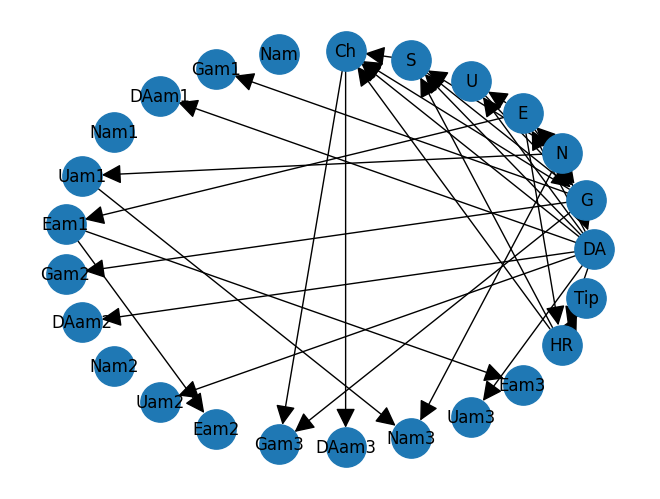

G -> ['Ch', 'Gam1', 'Gam2', 'Gam3']
U -> ['G']
Ch -> ['DAam3', 'Gam3']
Eam1 -> ['Eam2', 'Eam3']
DA -> ['U', 'Ch', 'E', 'HR', 'S', 'Uam2', 'Uam3', 'DAam1', 'DAam2']
E -> ['HR', 'G', 'U', 'Eam1']
Uam1 -> ['Nam3']
HR -> ['S', 'Ch', 'Tip']
N -> ['S', 'E', 'DA', 'Uam1', 'Nam3']
S -> ['Ch', 'G']


In [101]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.circular_layout(panels_best_structure_model) # Create a layout for nodes
nx.draw(panels_best_structure_model, pos, with_labels=True, arrowsize=30, node_size=800)
plt.show()

nodes_in_DAG = set()
for edge in panels_best_structure_model.edges():
    nodes_in_DAG.add(edge[0])
    nodes_in_DAG.add(edge[1])

# nodes_in_DAG imposes an ordering of variables for the plot
for feature in nodes_in_DAG:
    for key in depend_dict.keys():
        if key == feature:
            print(str(key)+" -> "+str(depend_dict[key]))

In [102]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization

panel_model = BayesianNetwork(panels_best_structure_model.edges())

# We need to manually add independent variables, as they do no appear in the DAG
panel_indep_variables = [variables for variables in merged_panel.columns if variables not in nodes_in_DAG]
for node in panel_indep_variables:
    panel_model.add_node(node)

panel_model.fit(merged_panel, estimator=ExpectationMaximization)

  0%|          | 0/100 [00:01<?, ?it/s]


## Combine CPDs

In [103]:
# add edges
combined_model = BayesianNetwork(ipums_best_structure_model.edges())
combined_model.add_edges_from(VS_best_structure_model.edges())
combined_model.add_edges_from(panels_best_structure_model.edges())

# add independent variables (if any)
for node in VS_indep_variables:
    combined_model.add_node(node)
for node in panel_indep_variables:
    combined_model.add_node(node)

# add cpds
combined_model.add_cpds(*ipums_model.get_cpds())

for cpd in VS_model.get_cpds():
    if cpd.variable not in ipums_nodes:
        combined_model.add_cpds(cpd)

for cpd in panel_model.get_cpds():
    if cpd.variable not in ipums_nodes:
        combined_model.add_cpds(cpd)

## Save the model

In [ ]:
from pgmpy.readwrite import BIFWriter

writer = BIFWriter(combined_model)
writer.write_bif('models/learnt_model.pgmx')